## Brqin Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)

MRI scan is one of the most common immage modalities that we encounter in the radiology field.
Other data modalities include:
- Computer Tomogrphy (CT),
- Ultrasound,
- X-Rays

In [6]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
import assignments.C1_W3.util as util

Magnetic resonance imaging (MRI) is an advances imaging technique that is used to observe a variety of diseases and parts of the body.

Neural networks can analyze these images individually (as a radiologist would) or combine them into a single 3D volume to make predictions.

In this assigment we'll build a multi-class segmentation model. We'll identify 3 different abnormlities in each image:
- edemas,
- non-enhancing tumors,
- enhancing tumors

In [7]:
def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())    
    
    return image, label

- Red - edma
- Green - non-enhancing tumor
- Blue - enhancing tumor

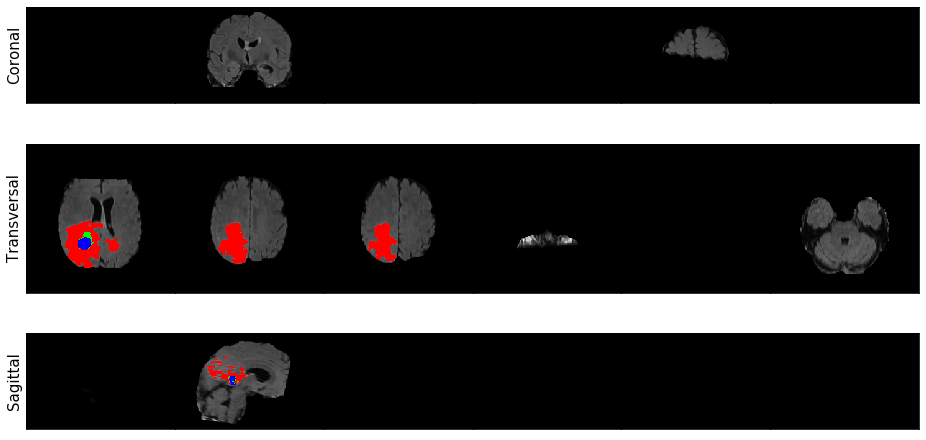

In [17]:
DATA_DIR = "assignments\\C1_W3\\BraTS-Data\\"
image, label = load_case(DATA_DIR + "imagesTr\BRATS_003.nii.gz", DATA_DIR + "labelsTr\BRATS_003.nii.gz")
image = util.get_labeled_image(image, label)

util.plot_image_grid(image)

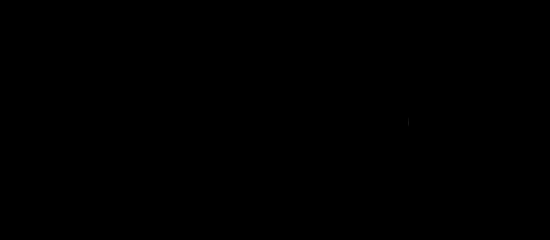

In [20]:
image, label = load_case(DATA_DIR + "imagesTr\BRATS_002.nii.gz", DATA_DIR + "labelsTr\BRATS_002.nii.gz")
util.visualize_data_gif(util.get_labeled_image(image, label))

#### Data Preprocessing using patches

##### Generate sub-volumes
We are going to first generate "patches" of our data which you can think of as sub-volumes of the whole MR images.

- The reason that we are generating patches is because a network that can process the entire volume at once will simply not fit inside our current environment's memory/GPU.
- Therefore we will be using this common technique to generate spatially consistent sub-volumes of our data, which can be fed into our network.
- Specifically, we will be generating randomly sampled sub-volumes of shape [160, 160, 16] from our images.
- Furthermore, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, we want to make sure that we pick patches that at least include some amount of tumor data.
- Therefore, we are only going to pick patches that have at most 95% non-tumor regions (so at least 5% tumor).
- We do this by filtering the volumes based on the values present in the background labels.

##### Standardization (mean 0, stdev 1)
Lastly, given that the values in MR images cover a very wide range, we will standardize the values to have a mean of zero and standard deviation of 1.

- This is a common technique in deep image processing since standardization makes it much easier for the network to learn.

In [26]:
import tensorflow as tf

def get_sub_volume(image, label, orig_x=240, orig_y=240, orig_z=155,
                  output_x=160, output_y=160, output_z=16,
                  num_classes=4, max_tries=1000, background_threshold=0.95):
    X = None
    Y = None
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-valume by sampling the corner voxel
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)        
        start_z = np.random.randint(orig_z - output_z + 1)        
        
        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                 start_y: start_y + output_y,
                 start_z: start_z + output_z]
        
        # one-hot encode the categories.
        # this adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = tf.keras.utils.to_categorical(y, num_classes)
        
        bgrd_ratio = y[:, :, :, 0].sum() / (output_x * output_y * output_z)
        
        tries += 1
        
        if bgrd_ratio < background_threshold:
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            X = np.moveaxis(X, -1, 0)
            
            y = np.moveaxis(y, -1, 0)
            
            y = y[1:, :, :, :]
            
            return X, y
        
    print(f"Tried {tries} times to find a sub-volume. Giving up...")


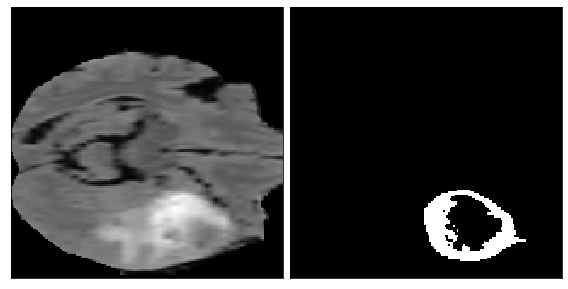

In [29]:
image, label = load_case(DATA_DIR + "imagesTr\BRATS_001.nii.gz", DATA_DIR + "labelsTr\BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)

util.visualize_patch(X[0, :, :, :], y[2])

#### Standarization

In [30]:
def standardize(image):
    stardardized_image = np.empty(image.shape)
    
    for c in range(image.shape[0]):
        for z in range(image.shape[3]):
            image_slice = image[c, :, :, z]
            
            centered = image_slice - image_slice.mean()
            
            if image_slice.std() != 0:
                centered_scaled = image_slice / image_slice.std()
            else:
                centered_scaled = centered
                
            stardardized_image[c, :, :, z] = centered_scaled
            
    return stardardized_image

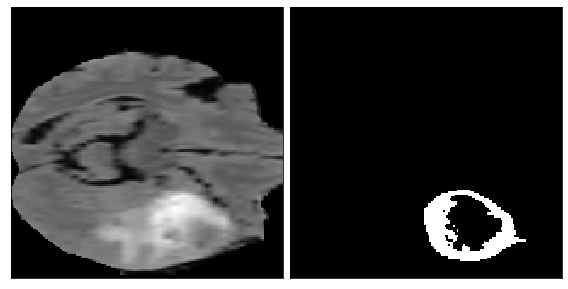

In [32]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

### Metrics

#### Dice Similarity Coefficient
Aside from the architecture, one of the most important elements of any deep learning method is the choice of our loss function.

A natural choice that you may be familiar with is the cross-entropy loss function.

However, this loss function is not ideal for segmentation tasks due to heavy class imbalance (there are typically not many positive regions).
A much more common loss for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap.

The Dice index ranges from 0 (complete mismatch)
To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth. 

Our model will map each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

The dice coefficient "DSC" is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero
 
ϵ  is a small number that is added to avoid division by zero

In [ ]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    dice_numerator = K.sum(2 * y_tr)
    return

#### Dice Coefficient for Multiple classes
Now that we have the single class case, we can think about how to approach the multi class context. 
- Remember that for this task, we want segmentations for each of the 3 classes of abnormality (edema, enhancing tumor, non-enhancing tumor). 
- This will give us 3 different dice coefficients (one for each abnormality class). 
- To combine these, we can just take the average. We can write that the overall dice coefficient is: 

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.

For any number of classes, the equation becomes:  
$$DC(f, x, y) = \frac{1}{N} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

In this case, with three categories, $C = 3$


In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    return

#### Soft Dice Loss
While the Dice Coefficient makes intuitive sense, it is not the best for training. 
- This is because it takes in discrete values (zeros and ones). 
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs. 

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth 
- In practice each $q_i$ will either be 0 or 1. 
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between 
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

You can also check that if $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.

#### Multi-Class Soft Dice Loss

We've explained the single class case for simplicity, but the multi-class generalization is exactly the same as that of the dice coefficient. 
- Since you've already implemented the multi-class dice coefficient, we'll have you jump directly to the multi-class soft dice loss.

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$